In [12]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import date, timedelta


repo_root = Path().resolve().parent
sys.path.append(str(repo_root))

In [13]:
from vnstock import Listing, Quote
list = Listing(source='vci')
VN30 = list.symbols_by_group('VN30').tolist()
#tickers = [t for t in VN30]
day_range = 180
tickers = ['HCM', 'ACB', 'HPG', 'SSI']
end = (date.today()).isoformat()
start = (date.today() - timedelta(days=day_range)).isoformat()



In [14]:
import src.fetch_info as fetch

raw = fetch.fetch_stock(tickers=tickers,interval='1d',hist=day_range, combine=False)


Processing batch ['HCM' 'ACB']
Done!

Processing batch ['HPG' 'SSI']
Done!



In [15]:
for i in raw:
    stock = raw[i]
    stock['ret'] = np.log(stock['close'] / stock['close'].shift(1)) 
    stock.dropna(subset=['ret'], inplace=True)
    stock['ticker'] = i
    print(stock.isna().sum().sum())


0
0
0
0


In [16]:
df = []
for i in raw:
    df.append(raw[i])
df = pd.concat(df)
df['mvol'] = df['close'] * df['volume']
df = df[['time','ticker','close', 'mvol', 'ret']]

In [17]:
from IPython.display import clear_output   
import src.mpt as mpt

sims = 4000

result = mpt.mpt_sim(df, sims)

result

Index(['ACB', 'HCM', 'HPG', 'SSI'], dtype='object', name='ticker')


,Return,Volatility,Weight
2151,0.002026,0.025480,"{'ACB': 0.014937358222547244, 'HCM': 0.0030869..."
2994,0.002005,0.025479,"{'ACB': 0.021781057602778722, 'HCM': 0.0154621..."
1857,0.001963,0.025110,"{'ACB': 0.02307390304010332, 'HCM': 0.02398728..."
2007,0.001956,0.024652,"{'ACB': 0.05073172782448149, 'HCM': 0.01167658..."
3941,0.001945,0.024365,"{'ACB': 0.11027542020267421, 'HCM': 0.01154338..."
...,...,...,...
1449,-0.000195,0.020433,"{'ACB': 0.04167644541651005, 'HCM': 0.86746095..."
1346,-0.000212,0.020793,"{'ACB': 0.04032820852617773, 'HCM': 0.89452071..."
1106,-0.000226,0.020828,"{'ACB': 0.0059891426820907895, 'HCM': 0.898045..."
1448,-0.000227,0.020445,"{'ACB': 0.08638235311585975, 'HCM': 0.88395317..."


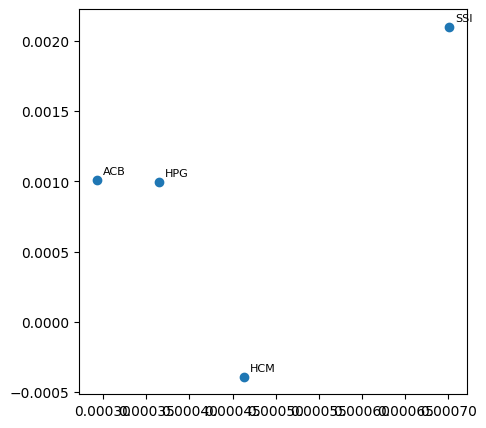

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
aggregate = df.groupby('ticker')['ret'].agg(['mean', 'std','var'])  

plt.figure(figsize=(5,5))
plt.scatter(aggregate['var'], aggregate['mean'])

for x, y, label in zip(aggregate['var'], aggregate['mean'], aggregate.index):
    plt.annotate(label, (x, y), xytext=(4, 4), textcoords="offset points", fontsize=8)



In [19]:
W = pd.DataFrame(result["Weight"].to_list(), index=result.index).add_prefix("w_")
result2 = pd.concat([result.drop(columns=["Weight"]), W], axis=1)
fin = result2.sort_values(['Return', 'Volatility'], ascending=[False, True])
fin


,Return,Volatility,w_ACB,w_HCM,w_HPG,w_SSI
2151,0.002026,0.025480,0.014937,0.003087,0.045929,0.936047
2994,0.002005,0.025479,0.021781,0.015462,0.030109,0.932648
1857,0.001963,0.025110,0.023074,0.023987,0.047844,0.905095
2007,0.001956,0.024652,0.050732,0.011677,0.054229,0.883363
3941,0.001945,0.024365,0.110275,0.011543,0.005798,0.872383
...,...,...,...,...,...,...
1449,-0.000195,0.020433,0.041676,0.867461,0.080877,0.009986
1346,-0.000212,0.020793,0.040328,0.894521,0.036173,0.028978
1106,-0.000226,0.020828,0.005989,0.898045,0.074544,0.021422
1448,-0.000227,0.020445,0.086382,0.883953,0.027483,0.002182


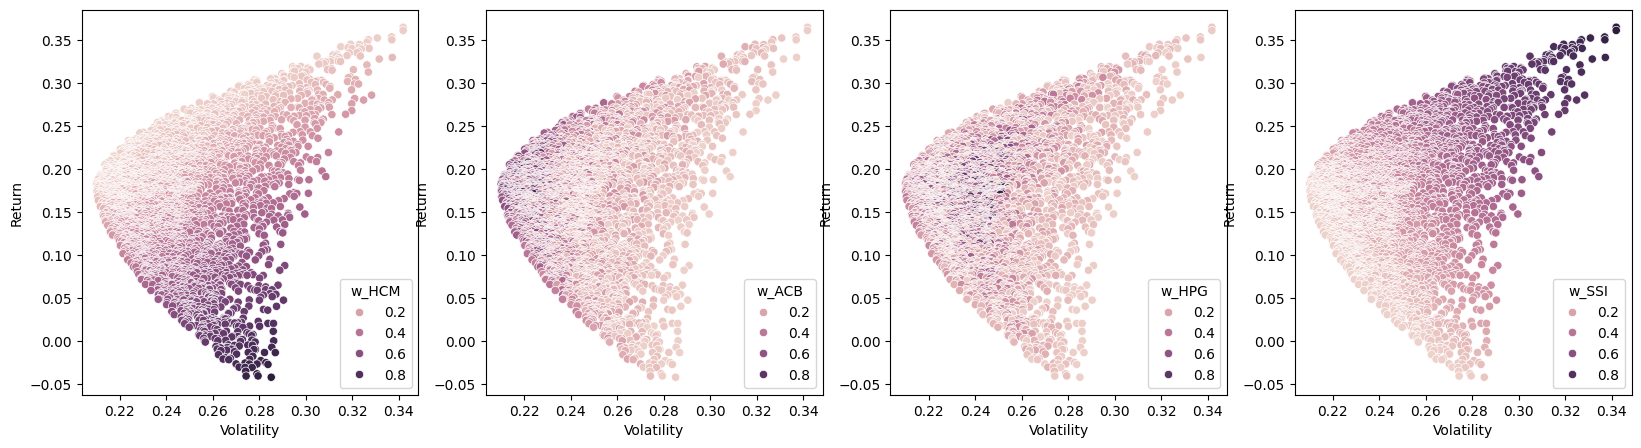

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import math 

fig, axs = plt.subplots(1, len(tickers), figsize=(20, 5), sharex=False, sharey=False)


for i in range(len(tickers)):
    sns.scatterplot(x=fin['Volatility'] * math.sqrt(day_range), y=fin['Return'] * day_range,hue=fin[f'w_{tickers[i]}'], ax=axs[i])


In [21]:
fin.head(100).agg(['mean', 'std'])

,Return,Volatility,w_ACB,w_HCM,w_HPG,w_SSI
mean,0.001764,0.022821,0.099392,0.042519,0.110934,0.747155
std,0.000096,0.001240,0.073728,0.035491,0.086563,0.081739


<Axes: xlabel='time', ylabel='close'>

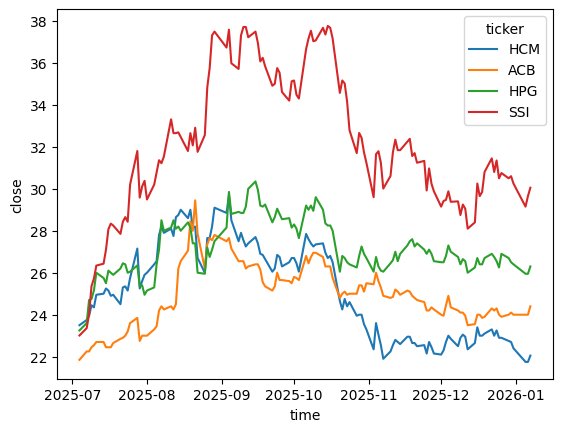

In [22]:
sns.lineplot(x=df['time'], y=df['close'], hue=df['ticker'])